In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (5,3)
import tqdm
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import pylab as pl
from matplotlib import collections  as mc
from sklearn.preprocessing import StandardScaler

path_folder = os.getcwd()

file_name_oa_offers = "offer_acceptance_offers.csv"
path_file_oa_offers = os.path.join(path_folder, file_name_oa_offers)
oa_offers = pd.read_csv(path_file_oa_offers)
print("Loaded offers df")
print(oa_offers.shape)

file_name_oa_orders = "offer_acceptance_orders.csv"
path_file_oa_orders = os.path.join(path_folder, file_name_oa_orders)
oa_orders = pd.read_csv(path_file_oa_orders)
print("Loaded orders df")
print(oa_orders.shape)



Loaded offers df
(707418, 14)
Loaded orders df
(280906, 17)


c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (9,10,11,12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
file_name_zipcode_coordinates = "zipcode_coordinates.csv"
path_file_zipcode_coordinates = os.path.join(path_folder, file_name_zipcode_coordinates)
zipcode_coordinates = pd.read_csv(path_file_zipcode_coordinates)
zipcode_coordinates["X_COORD"] /= 1.0e6
zipcode_coordinates["Y_COORD"] /= 1.0e6
print("Loaded zipcodes df")

Loaded zipcodes df


In [3]:
zipcode_coordinates["3DIGIT_ZIP"] = zipcode_coordinates["3DIGIT_ZIP"].astype(int).astype(str).str.zfill(3)

oa_orders = (
    oa_orders
    .merge(zipcode_coordinates, left_on=["DESTINATION_3DIGIT_ZIP"], right_on=["3DIGIT_ZIP"])
    .rename(columns={"X_COORD":"X_COORD_DEST","Y_COORD":"Y_COORD_DEST"})
    .drop(columns=["3DIGIT_ZIP"])
)

oa_orders = (
    oa_orders
    .merge(zipcode_coordinates, left_on=["ORIGIN_3DIGIT_ZIP"], right_on=["3DIGIT_ZIP"])
    .drop(columns=["3DIGIT_ZIP"])
)

In [4]:
def dataclean_ftl_duplicate_references(oa_orders):
    '''
    Part of a greater data cleaning on removing incorrect FTL labels,
    Removes FTL rows that have reference numbers that show up more than once, as those rows are incorrectly labeled FTL
    '''
    assert "TRANSPORT_MODE" in oa_orders.columns
    assert "REFERENCE_NUMBER" in oa_orders.columns
    oa_orders_ftl = oa_orders[oa_orders["TRANSPORT_MODE"]=="FTL"]
    oa_orders_ftl_unique = oa_orders_ftl.drop_duplicates(subset=["REFERENCE_NUMBER"],keep=False)
    oa_orders = pd.concat([oa_orders[oa_orders["TRANSPORT_MODE"]!="FTL"], oa_orders_ftl_unique],axis=0)
    oa_orders = oa_orders.reset_index(drop=True)
    assert (oa_orders[oa_orders["TRANSPORT_MODE"]=="FTL"]["REFERENCE_NUMBER"].value_counts()==1).all()
    return oa_orders
def dataclean_ftl_nonquote(oa):
    '''
    Part of a greater data cleaning on removing incorrect FTL labels,
    Removes FTL rows that don't have quote as the transport mode
    '''
    assert "OFFER_TYPE" in oa.columns
    assert "TRANSPORT_MODE" in oa.columns    
    oa = oa[~((oa["TRANSPORT_MODE"]=="FTL") & (oa["OFFER_TYPE"]!="quote"))]
    return oa



# Matt said that any duplicate references is likely an error
oa_orders = dataclean_ftl_duplicate_references(oa_orders)
print(oa_orders.shape)

origin_zipcode_column = oa_orders["ORIGIN_3DIGIT_ZIP"].astype(str)
destination_zipcode_column = oa_orders["DESTINATION_3DIGIT_ZIP"].astype(str)
oa_orders["PATH"] = origin_zipcode_column + "_TO_" + destination_zipcode_column
oa_orders = oa_orders.merge(
    oa_orders.groupby(["PATH"]).size().reset_index(name='PATH_ORDER_AMOUNT'), on=["PATH"]
)
print(oa_orders.shape)

In [6]:
oa_offers = oa_offers.merge(
    oa_offers.groupby(["REFERENCE_NUMBER"]).size().reset_index(name='ORDER_OFFER_AMOUNT'), on=["REFERENCE_NUMBER"]
)

In [7]:
oa_offers

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,OFFER_TYPE,SELF_SERVE,IS_OFFER_APPROVED,AUTOMATICALLY_APPROVED,MANUALLY_APPROVED,WAS_EVER_UNCOVERED,COVERING_OFFER,LOAD_DELIVERED_FROM_OFFER,RECOMMENDED_LOAD,VALID,ORDER_OFFER_AMOUNT
0,0629d63476c157a6cfe234f7a34422eb0ad94998c2d082...,"[\n ""ce3548db155049cc1ccce2da041cec607942e4f7...",2021-11-03 08:54:13,9546.00,pool,True,False,False,False,False,False,False,True,True,5
1,0629d63476c157a6cfe234f7a34422eb0ad94998c2d082...,"[\n ""ce3548db155049cc1ccce2da041cec607942e4f7...",2021-11-03 08:57:27,9159.00,pool,True,True,False,True,False,True,True,True,True,5
2,0629d63476c157a6cfe234f7a34422eb0ad94998c2d082...,"[\n ""ce3548db155049cc1ccce2da041cec607942e4f7...",2021-11-03 08:57:28,9288.00,pool,False,False,False,False,False,False,False,False,True,5
3,0629d63476c157a6cfe234f7a34422eb0ad94998c2d082...,"[\n ""ce3548db155049cc1ccce2da041cec607942e4f7...",2021-11-03 08:57:40,9159.00,pool,False,True,False,True,False,False,False,False,True,5
4,16badfc6202cb3f8889e0f2779b19218af4cbb736e56ac...,"[\n ""ce3548db155049cc1ccce2da041cec607942e4f7...",2021-11-03 09:05:43,11610.00,pool,False,False,False,False,False,False,False,False,True,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707413,6907e38c69f27485e91172f00c0ae9489465d3c7f7719e...,"[\n ""970ace12a50512b8aa57ec0a4022b54f5b095ca1...",2021-02-12 08:27:32,774.00,quote,False,False,False,False,False,True,True,False,True,1
707414,25633ae9c1f96e848da7e25f81525579c76086019e475f...,"[\n ""40d9c0666bf48ba6f5624357c58ea92d7e1044de...",2020-01-22 05:19:33,741.75,quote,False,False,False,False,False,False,False,False,True,1
707415,ab58ad627e6b1b11fc49d4b8a19821de9d8d4aee520820...,"[\n ""48ee5c8c73fe5f9b7c217c5988bf737909a0c80b...",2021-09-13 14:11:01,3612.00,quote,False,True,False,True,False,True,True,False,True,1
707416,07740fababf6abd1f22fcad8c838181a87b8b45b533da2...,"[\n ""53682bd6f01a0bf3529de991de6deb4e564e65ad...",2021-11-11 12:14:12,2128.50,quote,False,False,False,False,False,True,False,False,False,1


In [8]:
foreign_key_column_name = "REFERENCE_NUMBER"
oa = oa_offers.merge(oa_orders, on=[foreign_key_column_name])

oa = dataclean_ftl_nonquote(oa)

### **Geography Analysis**

In [9]:
reference_number_column_name = "REFERENCE_NUMBER"

In [10]:
oa["CREATED_ON_HQ"] = pd.to_datetime(oa["CREATED_ON_HQ"])
# preprocess CREATED_ON_HQ 

log_rate_usd_column = oa["RATE_USD"].apply(np.log1p)
oa["LOG(RATE_USD)"] = log_rate_usd_column
full_lognorm_rate_usd_column = StandardScaler().fit_transform(oa[["LOG(RATE_USD)"]])
oa["FULL_ZSCORE(LOG(RATE_USD))"] = full_lognorm_rate_usd_column

temp_groupby =  oa.groupby([reference_number_column_name])["LOG(RATE_USD)"]
groupwise_means_column  = temp_groupby.transform(np.mean)
groupwise_stds_column = temp_groupby.transform(np.std, ddof=0)

groupwise_lognorm_rate_usd_column = ((log_rate_usd_column - groupwise_means_column)/groupwise_stds_column)
groupwise_lognorm_rate_usd_column = groupwise_lognorm_rate_usd_column.fillna(0)
oa["GROUPWISE_ZSCORE(LOG(RATE_USD))"] = groupwise_lognorm_rate_usd_column

In [11]:
temp_zscore_groupby =  oa.groupby([reference_number_column_name])["GROUPWISE_ZSCORE(LOG(RATE_USD))"]
oa["GROUPWISE_MAX(GROUPWISE_ZSCORE(LOG(RATE_USD)))"] = temp_zscore_groupby.transform(np.max)
oa["GROUPWISE_MIN(GROUPWISE_ZSCORE(LOG(RATE_USD)))"] = temp_zscore_groupby.transform(np.min)

#optional to run, this just verifies the zscoring worked
def stdev(x): return np.std(x, ddof=0);
temp_check = oa.groupby([reference_number_column_name],as_index=False).agg(
    {"GROUPWISE_ZSCORE(LOG(RATE_USD))":[np.mean, stdev, np.max, np.min]})
temp_check.head(5)

In [12]:
#oa = oa.merge(
#    oa.groupby(["PATH"],as_index=False).size().reset_index(name='PATH_OFFER_AMOUNT')
#)
oa = oa.merge(
    oa_orders.groupby(["PATH"]).size().reset_index(name='PATH_ORDER_AMOUNT')
)

In [13]:
binary_groupwise_lognorm_rate_usd_column = groupwise_lognorm_rate_usd_column > 0
oa["GROUPWISE_ZSCORE(LOG(RATE_USD))>0"] = binary_groupwise_lognorm_rate_usd_column
oa["GROUPWISE_ZSCORE(LOG(RATE_USD))<=0"] = 1-binary_groupwise_lognorm_rate_usd_column

In [29]:
Y_UPPER_BOUND = 6.5
Y_LOWER_BOUND = 2.5
X_UPPER_BOUND = -7
X_LOWER_BOUND = -15

### Zipcode Scatterplots

In [30]:
def zipcode_aggregation_visualization(
    temp_df,
    temp_zipcode_endpoint_groupby_column_name,
    ax,
    ax_title_str,
    color_str,
):
    #assert temp_df in [oa, oa_orders]
    assert temp_zipcode_endpoint_groupby_column_name in ['ORIGIN_3DIGIT_ZIP', 'DESTINATION_3DIGIT_ZIP']
    aggregation = (
    temp_df[temp_zipcode_endpoint_groupby_column_name]
    .value_counts()
    .reset_index(name='count')
    .rename(columns={"index":"3DIGIT_ZIP"})
    .merge(zipcode_coordinates,on=["3DIGIT_ZIP"])
    )
    ax.set_title(ax_title_str)
    ax.set_ylim((Y_LOWER_BOUND, Y_UPPER_BOUND))
    ax.set_xlim((X_LOWER_BOUND,X_UPPER_BOUND))
    for i in tqdm.tqdm(range(len(aggregation))):
        row = aggregation.iloc[i]
        x = row["X_COORD"]
        y = row["Y_COORD"]
        size = (row["count"])*0.2
        opacity = 0.1
        color = color_str
        ax.scatter(x,y,s=size,c=color,alpha=opacity)
    return ax

temp_oa = oa
zipcode_counted_offers = (
    pd.concat([
    (
        temp_oa['ORIGIN_3DIGIT_ZIP']
        .value_counts()
        .reset_index(name='count')
    )
        ,
    (
        temp_oa['DESTINATION_3DIGIT_ZIP']
        .value_counts()
        .reset_index(name='count')
    
    )
], axis=0).groupby(["index"],as_index=False)
.agg({"count": np.sum})
.rename(columns={"index":"3DIGIT_ZIP"})
.merge(zipcode_coordinates,on=["3DIGIT_ZIP"])
)
fig, axs = plt.subplots(figsize=(16,8))
axs.set_title("Zipcodes sized by # of offers (both orig and dest)")
for i in tqdm.tqdm(range(len(zipcode_counted_offers))):
    row = zipcode_counted_offers.iloc[i]
    x = row["X_COORD"]
    y = row["Y_COORD"]
    size = (row["count"])*0.2
    opacity = 0.1
    color = "red"
    axs.scatter(x,y,s=size,c=color,alpha=opacity)

fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_aggregation_visualization(oa,'ORIGIN_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of offers (orig only)","red")

fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_aggregation_visualization(oa,'DESTINATION_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of offers (orig only)","teal")

100%|███████████████████████████████████████████████████████████████████████████████| 858/858 [00:01<00:00, 496.79it/s]


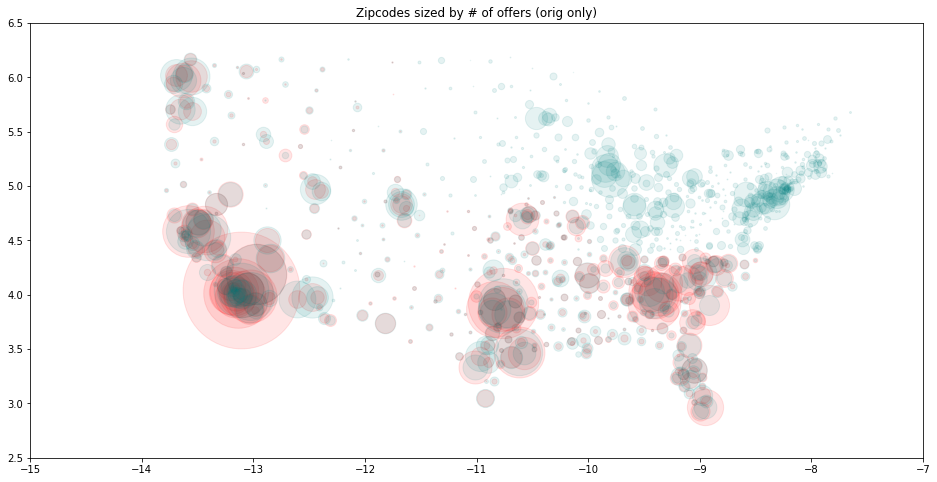

In [34]:
fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_aggregation_visualization(oa,'ORIGIN_3DIGIT_ZIP',axs,
                                  "","red")
axs = zipcode_aggregation_visualization(oa,'DESTINATION_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of offers (orig only)","teal")

temp_oa = oa_orders
zipcode_counted_offers = (
    pd.concat([
    (
        temp_oa['ORIGIN_3DIGIT_ZIP']
        .value_counts()
        .reset_index(name='count')
    )
        ,
    (
        temp_oa['DESTINATION_3DIGIT_ZIP']
        .value_counts()
        .reset_index(name='count')
    
    )
], axis=0).groupby(["index"],as_index=False)
.agg({"count": np.sum})
.rename(columns={"index":"3DIGIT_ZIP"})
.merge(zipcode_coordinates,on=["3DIGIT_ZIP"])
)
fig, axs = plt.subplots(figsize=(16,10))
axs.set_title("Zipcodes sized by # of orders (both orig and dest summed together)")
for i in tqdm.tqdm(range(len(zipcode_counted_offers))):
    row = zipcode_counted_offers.iloc[i]
    x = row["X_COORD"]
    y = row["Y_COORD"]
    size = (row["count"])*0.2
    opacity = 0.1
    color = "purple"
    axs.scatter(x,y,s=size,c=color,alpha=opacity)

fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_aggregation_visualization(oa_orders,'ORIGIN_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of orders (orig only)","red")

fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_aggregation_visualization(oa_orders,'DESTINATION_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of orders (dest only)","teal")

100%|███████████████████████████████████████████████████████████████████████████████| 886/886 [00:01<00:00, 666.52it/s]


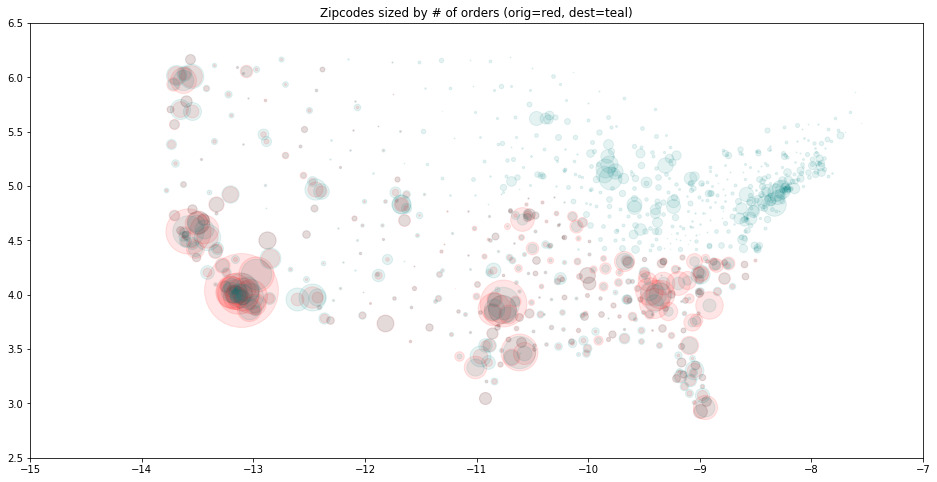

In [38]:
fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_aggregation_visualization(oa_orders,'ORIGIN_3DIGIT_ZIP',axs,
                                  "","red")
axs = zipcode_aggregation_visualization(oa_orders,'DESTINATION_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of orders (orig=red, dest=teal)","teal")

**Evaluation**
* Points of Interest:
    * Southern California (LA, SD)
    * Bay Area
    * Seattle
    * Texas (Dallas & Houston)
    * Florida
    * Atlanta?
    * NYC

**Brainstorming Ideas**

* Maybe we can do clustering on this.
    * Treat the dot weights as a 3rd dimension (acts like an axis for urban vs rural) and do DBSCAN or KMeans Clustering.
    * So that metropolitan areas are treated as clumps


In [14]:
agg_column_names = [
 'RATE_USD',
 'LOG(RATE_USD)',
 'GROUPWISE_ZSCORE(LOG(RATE_USD))',
 'GROUPWISE_ZSCORE(LOG(RATE_USD))>0',
 'GROUPWISE_ZSCORE(LOG(RATE_USD))<=0',
  "GROUPWISE_MAX(GROUPWISE_ZSCORE(LOG(RATE_USD)))",
  "GROUPWISE_MIN(GROUPWISE_ZSCORE(LOG(RATE_USD)))",
 'FULL_ZSCORE(LOG(RATE_USD))']

In [15]:
aggdict = dict()
for column_name in agg_column_names:
    aggdict[column_name] = np.mean

temp_groupby = (
    oa
    .groupby(["X_COORD","Y_COORD","X_COORD_DEST","Y_COORD_DEST"],as_index=False)
    .agg(aggdict))

In [16]:
connections = temp_groupby

In [17]:
def remove_hawaii(connections):
    hawaii = connections["X_COORD_DEST"].min()
    connections = connections[connections["X_COORD_DEST"] > hawaii]
    return connections

In [18]:
connections = remove_hawaii(connections)

In [19]:
def get_line(i):
    row = connections.iloc[i]
    ox = row["X_COORD"]#.values[0]
    oy = row["Y_COORD"]#.values[0]
    dx = row["X_COORD_DEST"]#.values[0]
    dy = row["Y_COORD_DEST"]#.values[0]
    return [(ox, oy), (dx, dy)]
    
lines = [get_line(i) for i in tqdm.tqdm(range(connections.shape[0]))]

100%|██████████████████████████████████████████████████████████████████████████| 27256/27256 [00:05<00:00, 5070.05it/s]


In [20]:
import matplotlib
from matplotlib import cm

sigmoid = lambda x: x/(1+np.exp(-x))
def visibility_modifier_array(x):
    if agg_column_name not in ["FULL_ZSCORE(LOG(RATE_USD))","GROUPWISE_ZSCORE(LOG(RATE_USD))"]:
        return np.log1p(x) 
    else:
        if agg_column_name == "GROUPWISE_ZSCORE(LOG(RATE_USD))":
            return x#**3
        return x
def groupwise_min_max_scale(x):
    numerator = (x - connections["GROUPWISE_MIN(GROUPWISE_ZSCORE(LOG(RATE_USD)))"])
    denominator = (
connections["GROUPWISE_MAX(GROUPWISE_ZSCORE(LOG(RATE_USD)))"] - connections["GROUPWISE_MIN(GROUPWISE_ZSCORE(LOG(RATE_USD)))"]
        )
    rescaled_x = numerator/denominator
    rescaled_x = np.nan_to_num(rescaled_x,0,posinf=0,neginf=0)
    return rescaled_x
def min_max_scale(x):
    numerator = (x - np.min(x))
    denominator = (np.max(x) - np.min(x))
    rescaled_x = numerator/denominator
    rescaled_x = np.nan_to_num(rescaled_x,0,posinf=0,neginf=0)
    return rescaled_x
def visibility_modifier_linewidth(x):
    if agg_column_name not in ["FULL_ZSCORE(LOG(RATE_USD))","GROUPWISE_ZSCORE(LOG(RATE_USD))"]:
        return np.log1p(x)  
    else:
        # if x is an array that has numbers below 0 (i.e. a z-scored column), rescale it to be positive
        # since plotted linewidth cannot understand negative width
        # use min-max-scaling to make it positive from 0 to 1
        
        if agg_column_name == "GROUPWISE_ZSCORE(LOG(RATE_USD))":
            rescaled_x = groupwise_min_max_scale(x)
            
            rescaled_x = (1-rescaled_x)**10
        else:
            rescaled_x = min_max_scale(x)
        return rescaled_x**10
def get_values(connections, agg_column_name):
    values = connections[agg_column_name]
    # re-weight the values by usage
    #values /= connections["PATH_ORDER_AMOUNT"]
    return values
def get_linewidths(connections, agg_column_name):
    values = get_values(connections, agg_column_name)
    return visibility_modifier_linewidth(values)
def get_array(connections, agg_column_name):
    values = get_values(connections, agg_column_name)
    return visibility_modifier_array(values)
def get_rgba(connections, agg_column_name):
    values = get_values(connections, agg_column_name)
    #cmap = matplotlib.cm.get_cmap('Spectral')
    cmap = cm.jet
    #cmap = cm.hsv
    norm = matplotlib.colors.Normalize(vmin=np.min(values), vmax=np.max(values))
    rgba_colors = np.array([cmap(norm(x)) for x in values])
    if agg_column_name in ["GROUPWISE_ZSCORE(LOG(RATE_USD))"]:
        alphas = (groupwise_min_max_scale(values))#*0.001
    else:
        alphas = (min_max_scale(values))#*0.001
    rgba_colors[:,-1] = (alphas)*0.00001
    return rgba_colors

In [21]:
agg_column_names = list(aggdict.keys())
agg_column_name = agg_column_names[-1]
#agg_column_name = "OFFER_AMOUNT"
agg_column_name = "GROUPWISE_ZSCORE(LOG(RATE_USD))>0"
agg_column_name = "GROUPWISE_ZSCORE(LOG(RATE_USD))<=0"
agg_column_name = "GROUPWISE_ZSCORE(LOG(RATE_USD))"

#agg_column_name = "FULL_ZSCORE(LOG(RATE_USD))"

print(agg_column_name)
# the green florida map still works even with 
# new oa, bare oa, reference_number_column_name = "REFERENCE_NUMBERS", for full_zscore(lognorm(rate_usd))

GROUPWISE_ZSCORE(LOG(RATE_USD))


In [22]:
lc = mc.LineCollection(lines, 
                       array = (get_array(connections, agg_column_name)),
                       colors = (get_rgba(connections, agg_column_name)),
                       linewidths = (get_linewidths(connections, agg_column_name)),
                       alpha=0.1
                      )

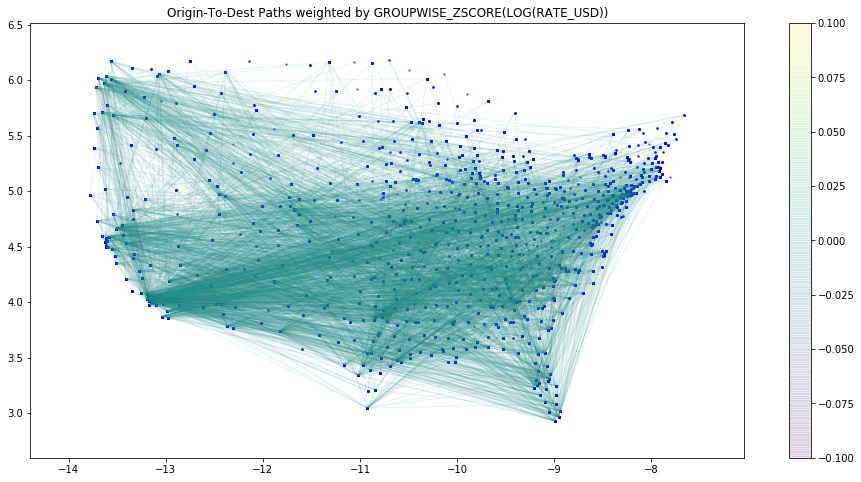

In [23]:
fig2, ax2 = plt.subplots(figsize=(16,8))
ax2.scatter(connections["X_COORD"], connections["Y_COORD"], alpha=0.5, c="yellow", s=2)
ax2.scatter(connections["X_COORD_DEST"], connections["Y_COORD_DEST"], alpha=0.5, c="blue", s=2)
ax2.add_collection(lc)
ax2.autoscale()
ax2.margins(0.1)
ax2.set_title("Origin-To-Dest Paths weighted by {0}".format(agg_column_name))
fig2.colorbar(lc)

In [25]:
# orig or dest for groupby
# avg name
is_origin = 1
agg_column_name = "OFFER_AMOUNT"
all_zipcoord_column_names = ["X_COORD","Y_COORD"] + ["X_COORD_DEST","Y_COORD_DEST"]
if is_origin==1:
    zipcoord_column_names = ["X_COORD","Y_COORD"]
    zipcoord_groupby_column_name = "ORIGIN_3DIGIT_ZIP"
else:
    zipcoord_column_names = ["X_COORD_DEST","Y_COORD_DEST"]
    zipcoord_groupby_column_name = "DESTINATION_3DIGIT_ZIP"

In [26]:
zipcode_groupby_endpoint_type = (oa.groupby([zipcoord_groupby_column_name],as_index=False)[agg_column_name].mean())

In [27]:
zipcode_groupby_endpoint_type.head(5)

,ORIGIN_3DIGIT_ZIP,OFFER_AMOUNT
0,270,6.207334
1,271,7.488189
2,272,6.294565
3,273,6.229294
4,274,11.931174


In [28]:
zipcode_groupby_endpoint_type.shape[0]

399

In [29]:
zipcode_groupby_endpoint_type_with_coords = (
    zipcode_groupby_endpoint_type.merge(
        oa[[zipcoord_groupby_column_name]+all_zipcoord_column_names],
                                    on=[zipcoord_groupby_column_name],
                                    how="left" # meaningless
    )
)

In [30]:
zipcode_groupby_endpoint_type_with_coords.shape[0]

833137

In [31]:
zipcode_groupby_endpoint_type_with_coords_unique = zipcode_groupby_endpoint_type_with_coords.drop_duplicates()

In [32]:
zipcode_groupby_endpoint_type.shape[0], zipcode_groupby_endpoint_type_with_coords_unique.shape[0]

(399, 31905)

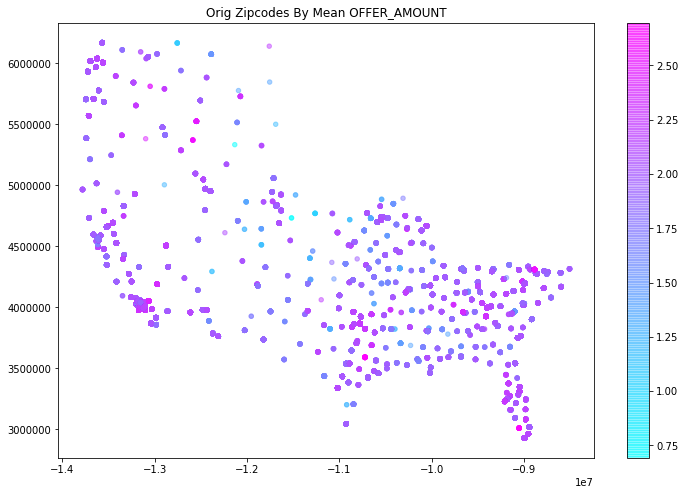

In [33]:
if is_origin:
    figsize = (12,8)
else:
    figsize = (12,6)

fig, axs = plt.subplots(figsize=figsize)
s = axs.scatter(
    zipcode_groupby_endpoint_type_with_coords_unique[zipcoord_column_names[0]],
    zipcode_groupby_endpoint_type_with_coords_unique[zipcoord_column_names[1]],
    c = zipcode_groupby_endpoint_type_with_coords_unique[agg_column_name].apply(np.log1p),
    alpha = 0.5,
    s = 10*(is_origin+1),
    cmap="cool"
)
zipcoord_type = ["Dest","Orig"][is_origin]
axs.set_title("{0} Zipcodes By Mean {1}".format(zipcoord_type, agg_column_name))
fig.colorbar(s)

In [34]:
connections = zipcode_groupby_endpoint_type_with_coords.groupby(
    ["X_COORD","Y_COORD","X_COORD_DEST","Y_COORD_DEST"],
    as_index=False
)[agg_column_name].count()

In [35]:
assert connections.shape[0] == temp_groupby.shape[0]
connections.head(5)

,X_COORD,Y_COORD,X_COORD_DEST,Y_COORD_DEST,OFFER_AMOUNT
0,-1.377933e+07,4.966830e+06,-1.371261e+07,5.571243e+06,2
1,-1.377933e+07,4.966830e+06,-1.362103e+07,6.040352e+06,13
2,-1.377933e+07,4.966830e+06,-1.358547e+07,4.589622e+06,9
3,-1.377933e+07,4.966830e+06,-1.350084e+07,4.669768e+06,1
4,-1.377933e+07,4.966830e+06,-1.341369e+07,4.527873e+06,2


In [38]:
def get_line(i):
    row = zipcode_groupby_endpoint_type_with_coords.iloc[i]
    ox = row["X_COORD"]#.values[0]
    oy = row["Y_COORD"]#.values[0]
    dx = row["X_COORD_DEST"]#.values[0]
    dy = row["Y_COORD_DEST"]#.values[0]
    return [(ox, oy), (dx, dy)]
    
lines = [get_line(i) for i in tqdm.tqdm(range(connections.shape[0]))]


100%|██████████████████████████████████████████████████████████████████████████| 31905/31905 [00:11<00:00, 2883.65it/s]


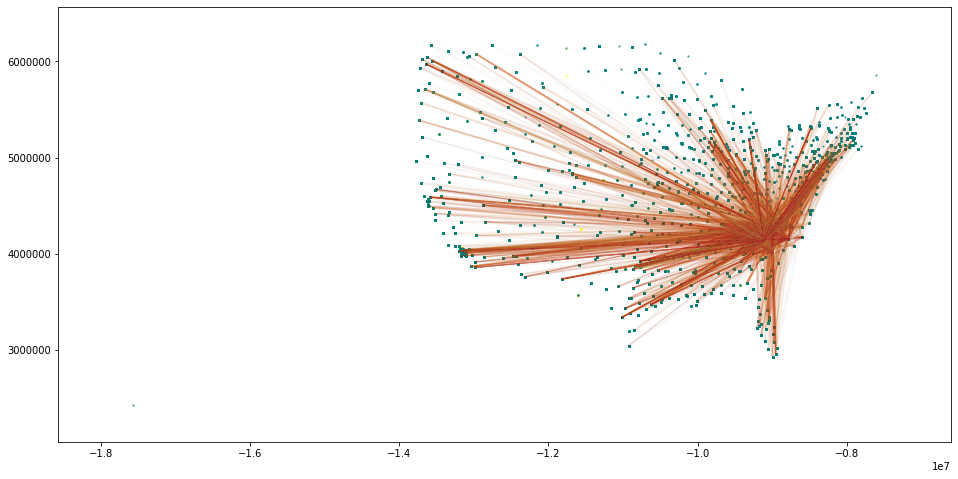

In [39]:

lc = mc.LineCollection(lines, 
                       #colors=c, 
                       array=np.log1p(connections[agg_column_name]),
                       cmap="RdYlGn",
                       alpha=0.01,
                       linewidths=0.5*np.log1p(connections[agg_column_name])
                       
                      )
fig2, ax2 = pl.subplots(figsize=(16,8))
ax2.scatter(connections["X_COORD"],
              connections["Y_COORD"],
              alpha=0.5,
           c="yellow",
              s=2)
ax2.scatter(connections["X_COORD_DEST"],
              connections["Y_COORD_DEST"],
              alpha=0.5,
           c="teal",
              s=2)
ax2.add_collection(lc)
ax2.autoscale()
ax2.margins(0.1)
#fig.colorbar()